## Recordings segments loader

In [1]:
import os
import json
from functools import reduce

# is_single_speaker_segment [VALIDATED]
# validates if a segment has a single speaker who belongs to the speakers list. 
def is_single_speaker_segment(segment, valid_speakers_ids = ['A', 'B']):
    return len(segment['speakers']) == 1 and segment['speakers'][0]['speaker_id'] in valid_speakers_ids

# is_valid_segment [VALIDATED]
# validates if a segment meets a maximum number of speakers,
# and that all the speakers in the segment belong to a list.
def is_valid_segment(segment, maximum_speakers_length = 2, valid_speakers_ids = ['A', 'B']):
    speakers_ids = [speaker['speaker_id'] for speaker in segment['speakers']]
    speakers_ids = list(set(speakers_ids))
    return len(speakers_ids) <= maximum_speakers_length and \
        all(speaker_id in valid_speakers_ids for speaker_id in speakers_ids)

# load_recordings_segments [VALIDATED]
# loads the recordings segments data from the .json files located in a directory 
def load_recordings_segments(directory, validation_function):
    filenames = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]
    filenames.sort()
    recordings_segments = {}
    recordings_length = len(filenames)
    recordings_count = 0
    segments_original = 0
    segments_filtered = 0
    for filename in filenames:
        recording_id = filename.split('.')[0]
        filepath = os.path.join(directory, filename)
        file = open(filepath, 'r')
        recordings_segments[recording_id] = [json.loads(line) for line in file.readlines()]
        file.close()
        segments_original += len(recordings_segments[recording_id])
        recordings_segments[recording_id] = list(filter(validation_function, recordings_segments[recording_id]))
        segments_filtered += len(recordings_segments[recording_id])
        recordings_count += 1
        print(directory + ' loading ' + str(recordings_count) + '/' + str(recordings_length), end = '\r')
    print(directory, 'loaded', str(recordings_count) + '/' + str(recordings_length) + ',', round(segments_filtered / segments_original, 2), 'segments left.')
    return recordings_segments

# speakers_get_indexes [VALIDATED]
# used to convert a (speakers_ids, index) list to a speakers_ids => [indexes] dictionary
def speakers_get_indexes(accumulator, speakers_tuple):
    speaker_ids, index = speakers_tuple
    speaker_ids = ','.join(speaker_ids)
    if speaker_ids in accumulator:
        accumulator[speaker_ids].append(index)
    else:
        accumulator[speaker_ids] = [index]
    return accumulator

# balance_segments [VALIDATED]
# balances the recording segments data to meet a minimum of speakers per recording,
# and a minimum of segments per speaker.
def balance_segments(recordings_segments,
                     minimum_speakers_length = 2,
                     minimum_speaker_segments = 3,
                     include_overlaps = False):
    new_recordings_segments = {}
    for recording_id in recordings_segments:
        recording_segments = recordings_segments[recording_id]
        # ----- Obtaining speakers indexes ----- #
        speakers_indexes = [(sorted(list(set([speaker['speaker_id'] for speaker in segment['speakers']]))), index) for index, segment in enumerate(recording_segments)]
        speakers_indexes = reduce(speakers_get_indexes, speakers_indexes, {})
        # ----- Removing overlaps ----- #
        if not include_overlaps:
            for speakers_ids in list(speakers_indexes.keys()):
                if len(speakers_ids.split(',')) > 1:
                    del speakers_indexes[speakers_ids]
        speakers_lengths = [(speakers_ids, len(speakers_indexes[speakers_ids])) for speakers_ids in speakers_indexes]
        speakers_lengths.sort(key = lambda x: x[1])
        speakers_lengths_min = speakers_lengths[0][1]
        if len(speakers_lengths) >= minimum_speakers_length and speakers_lengths_min >= minimum_speaker_segments:
            recording_indexes = []
            for speakers_ids in speakers_indexes:
                speakers_indexes[speakers_ids] = speakers_indexes[speakers_ids][:speakers_lengths_min]
                recording_indexes += speakers_indexes[speakers_ids]
            new_recordings_segments[recording_id] = [segment for index, segment in enumerate(recordings_segments[recording_id]) if index in recording_indexes]
    print('Recordings left: ' + str(len(new_recordings_segments)) + '/' + str(len(recordings_segments)))
    return new_recordings_segments

## Recordings dataset

In [2]:
from torch.utils.data import Dataset
import random
import numpy as np
import itertools

def generate_speaker_model(speakers_segments_indexes,
                           recordings_segments,
                           segments_length,
                           vector = 'ivectors',
                           selection = 'first',
                           indexes = []):
    if selection == 'first':
        selected_segments = [recordings_segments[recording_id][index] for recording_id, index, real in speakers_segments_indexes[:segments_length]]
    elif selection == 'random':
        selected_segments = [recordings_segments[recording_id][index] for recording_id, index, real in random.sample(speakers_segments_indexes, segments_length if segments_length < len(speakers_segments_indexes) else len(speakers_segments_indexes))]
    else:
        print('ERROR: unknown speaker model segments selection strategy.')
    selected_vectors = [np.asarray(segment[vector][0]['value']) for segment in selected_segments]
    return np.sum(selected_vectors, 0) / len(selected_vectors)

def get_speakers_segments_indexes(acc, recording_id_index_real, recordings_segments):
    recording_id, index, real = recording_id_index_real
    segment = recordings_segments[recording_id][index]
    speakers_ids = ','.join(sorted([speaker['speaker_id'] for speaker in segment['speakers']]))
    if speakers_ids not in acc:
        acc[speakers_ids] = []
    acc[speakers_ids].append(recording_id_index_real)
    return acc

class Recordings_dataset(Dataset):
    def __init__(self,
                 recordings_segments,
                 recordings_ids = None,
                 vector = 'ivectors',
                 models_container_length = 2,
                 models_container_include_zeros = True,
                 models_container_include_overlaps = False,
                 models_generation_lengths = [3],
                 models_generation_selection = 'first',
                 include_false_segments = False):
        # ----- Saving the recordings ids ----- #
        if recordings_ids is None:
            recordings_ids = [recording_id for recording_id in recordings_segments]
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids] 
        # ----- Saving the recordings segments ----- #
        self.recordings_segments = recordings_segments
        # ----- Saving the arguments ----- #
        self.vector = vector
        self.models_container_length = models_container_length
        self.models_container_include_zeros = models_container_include_zeros
        self.models_container_include_overlaps = models_container_include_overlaps
        self.models_generation_lengths = models_generation_lengths
        self.models_generation_selection = models_generation_selection
        self.include_false_segments = include_false_segments
        
        self.recordings_data = {}
        self.recordings_models = {}
        
        # ----- Initializing the recordings data ----- #
        for recording_id in self.recordings_ids:
            self.recordings_data[recording_id] = {}
        
        # ----- Saving the recordings segments indexes ----- #
        for recording_id in self.recordings_data:
            recording_data = self.recordings_data[recording_id]
            recording_data['recording_segments_indexes'] = [(recording_id, index, True) for index, segment in enumerate(self.recordings_segments[recording_id])]
            
        # ----- Obtaining the recordings speakers segments indexes ----- #
        for recording_id in self.recordings_data:
            recording_data = self.recordings_data[recording_id]
            recording_data['speakers_segments_indexes'] = reduce(lambda acc, recording_id_index_real: get_speakers_segments_indexes(acc, recording_id_index_real, self.recordings_segments), recording_data['recording_segments_indexes'], {})
            # ----- Obtaining the max speaker segments length ----- #
            recording_data['speakers_segments_indexes_lengths_max'] = max([len(recording_data['speakers_segments_indexes'][speakers_ids]) for speakers_ids in recording_data['speakers_segments_indexes']])
      
        # ----- Generating the recordings speakers models ----- #
        for recording_id in self.recordings_data:
            self.recordings_models[recording_id] = []
            recording_data = self.recordings_data[recording_id]
            recording_data['speakers_models'] = {}
            for speakers_ids in recording_data['speakers_segments_indexes']:
                recording_data['speakers_models'][speakers_ids] = {}
                for models_generation_length in models_generation_lengths:
                    speakers_model = generate_speaker_model(recording_data['speakers_segments_indexes'][speakers_ids], self.recordings_segments, models_generation_length, self.vector, self.models_generation_selection)
                    model_segment = {}
                    model_segment[vector] = [{ 'value': speakers_model }]
                    model_segment['speakers'] = [{ 'speaker_id': speakers_ids }]
                    self.recordings_models[recording_id].append(model_segment)
                    recording_data['speakers_models'][speakers_ids][models_generation_length] = [speakers_model]
        
        # ----- Generating the recordings speakers models permutations ----- #
        for recording_id in self.recordings_data:
            recording_data = self.recordings_data[recording_id]
            if self.models_container_include_zeros:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()) + ['0' for _ in range(self.models_container_length)], self.models_container_length))
            else:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()), self.models_container_length))
            recording_data['permutations'] = sorted(set(recording_data['permutations']))
            if not self.models_container_include_overlaps:
                recording_data['permutations'] = [permutation for permutation in recording_data['permutations'] if all(len(speakers_ids.split(',')) == 1 for speakers_ids in permutation)]

        # ----- Generatign false segments ----- #
        if self.include_false_segments == 'segments':
            for recording_id in self.recordings_data:
                recording_data = self.recordings_data[recording_id]
                other_recordings_segments_indexes = []
                for other_recording_id in self.recordings_segments:
                    if other_recording_id != recording_id:
                        other_recordings_segments_indexes += [(other_recording_id, index, False) for index, segment in enumerate(self.recordings_segments[other_recording_id])]
                if len(other_recordings_segments_indexes) >= recording_data['speakers_segments_indexes_lengths_max']:
                    other_recordings_segments_indexes = random.sample(other_recordings_segments_indexes, recording_data['speakers_segments_indexes_lengths_max'])
                    options = [recording_data['recording_segments_indexes'], other_recordings_segments_indexes]
                    options_lengths = [len(option) for option in options]
                    new_recording_segments_indexes = []
                    while sum(options_lengths) > 0:
                        options_indexes = list(itertools.chain(*[[index] * len(option) for index, option in enumerate(options)]))
                        option_index = random.choice(options_indexes)
                        new_recording_segments_indexes.append(options[option_index].pop(0))
                        options_lengths = [len(option) for option in options]
                    recording_data['recording_segments_indexes'] = new_recording_segments_indexes
        elif self.include_false_segments == 'models':
            for recording_id in self.recordings_data:
                recording_data = self.recordings_data[recording_id]
                other_recordings_segments_indexes = []
                for other_recording_id in self.recordings_models:
                    if other_recording_id != recording_id:
                        other_recordings_segments_indexes += [(other_recording_id, index, False) for index, segment in enumerate(self.recordings_models[other_recording_id])]
                other_recordings_segments_indexes = random.sample(other_recordings_segments_indexes, int(0.5 * recording_data['speakers_segments_indexes_lengths_max'] if recording_data['speakers_segments_indexes_lengths_max'] < len(other_recordings_segments_indexes) else len(other_recordings_segments_indexes)))
                
                options = [recording_data['recording_segments_indexes'], other_recordings_segments_indexes]
                options_lengths = [len(option) for option in options]
                new_recording_segments_indexes = []
                while sum(options_lengths) > 0:
                    options_indexes = list(itertools.chain(*[[index] * len(option) for index, option in enumerate(options)]))
                    option_index = random.choice(options_indexes)
                    new_recording_segments_indexes.append(options[option_index].pop(0))
                    options_lengths = [len(option) for option in options]
                recording_data['recording_segments_indexes'] = new_recording_segments_indexes
                
        # ----- Obtaining the dataset length ----- #
        self.recordings_length = 0
        self.recordings_map = []
        for recording_id in self.recordings_data:
            recording_data = self.recordings_data[recording_id]
            recording_data['permutations_map'] = []
            recording_data['permutations_length'] = 0
            for index, permutation in enumerate(recording_data['permutations']):
                speakers_models_length = int(np.prod([np.sum([len(recording_data['speakers_models'][speakers_ids][models_generation_length]) for models_generation_length in recording_data['speakers_models'][speakers_ids]]) for speakers_ids in permutation if speakers_ids != '0']))
                recording_data['permutations_map'].append((recording_data['permutations_length'], recording_data['permutations_length'] + speakers_models_length - 1, index))
                recording_data['permutations_length'] += speakers_models_length
            recording_data['length'] = len(recording_data['recording_segments_indexes']) * recording_data['permutations_length']
            self.recordings_map.append((self.recordings_length, self.recordings_length + recording_data['length'] - 1, recording_id))
            self.recordings_length += recording_data['length']
    def __len__(self):
        return self.recordings_length
    def __getitem__(self, idx):
        recording_limits = list(filter(lambda recording_limits: recording_limits[0] <= idx and idx <= recording_limits[1], self.recordings_map))[0]
        recording_idx = idx - recording_limits[0]
        recording_id = recording_limits[2]
        recording_data = self.recordings_data[recording_id]
        
        segment_id, segment_idx = divmod(recording_idx, recording_data['permutations_length'])
        segment_recording_id, segment_index, segment_real = recording_data['recording_segments_indexes'][segment_id]
        if not segment_real and self.include_false_segments == 'models':
            segment = self.recordings_models[segment_recording_id][segment_index]
        else:
            segment = self.recordings_segments[segment_recording_id][segment_index]
        vector = np.asarray(segment[self.vector][0]['value'])
        
        permutation_limits = list(filter(lambda permutation_limits: permutation_limits[0] <= segment_idx and segment_idx <= permutation_limits[1], recording_data['permutations_map']))[0]
        permutation_idx = segment_idx - permutation_limits[0]
        permutation_index = permutation_limits[2]
        permutation = recording_data['permutations'][permutation_index]
        
        speakers_models_lengths = [np.sum([len(recording_data['speakers_models'][speakers_ids][models_generation_length]) for models_generation_length in recording_data['speakers_models'][speakers_ids]])  if speakers_ids != '0' else 1 for speakers_ids in permutation]
        models_container = []
        model_index = permutation_idx
        for i, length_i in enumerate(speakers_models_lengths):
            if i != len(speakers_models_lengths) - 1:
                model_index, remainder = divmod(model_index, np.sum(speakers_models_lengths[i + 1:]))
            else:
                model_index = remainder
            models_container.append(recording_data['speakers_models'][permutation[i]][self.models_generation_lengths[model_index]][0] if permutation[i] != '0' else np.random.uniform(-0.1, 0.1, len(vector)))
        
        models_weigths = np.asarray([len(recording_data['speakers_segments_indexes'][speakers_ids]) if speakers_ids != '0' else recording_data['speakers_segments_indexes_lengths_max'] for speakers_ids in permutation])
        models_weigths_sum = np.sum(models_weigths)
        models_weigths = np.ones(len(models_weigths)) - models_weigths / models_weigths_sum
        
        targets_ids = [speaker['speaker_id'] for speaker in segment['speakers']]
        
        x = [vector] + models_container
        if segment_real:
            if self.models_container_include_overlaps:
                targets_ids = ','.join(sorted(list(set(targets_ids))))
                y = np.asarray([speakers_ids == targets_ids for speakers_ids in permutation], dtype = float)
            else:
                y = np.asarray([speaker_id in targets_ids for speaker_id in permutation], dtype = float) / len(targets_ids)
        else:
            y = np.zeros(len(permutation))
        z = models_weigths

        return x, y, z, segment_real

## Live plotter

In [3]:
# %load live_graph.py
%matplotlib notebook
import matplotlib.pyplot as plt

class Live_graph:
    def __init__(self, validation_threshold):
        self.plt_count = -1
        self.validation_threshold = validation_threshold
        self.plt_thr = ([self.plt_count], [self.validation_threshold])
        self.plt_loss = ([self.plt_count], [1])
        self.plt_valid = ([self.plt_count], [1])
        self.plt_test = ([self.plt_count], [1])
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        self.line0, = self.ax.plot(self.plt_thr[0], self.plt_thr[1], 'k--', label = 'Threshold') # Threshold line
        self.line1, = self.ax.plot(self.plt_loss[0], self.plt_loss[1], '--', label = 'Training') # Training loss
        self.line2, = self.ax.plot(self.plt_valid[0], self.plt_valid[1], label = 'Validation')   # Validation loss
        self.line3, = self.ax.plot(self.plt_test[0], self.plt_test[1], label = 'Test')           # Test loss
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()
        self.ax.set_xlim(-1, 0)
        self.ax.set_ylim(0, 0.5)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    def step(self, training, validation, test = -1):
        self.plt_count += 1
        self.plt_thr[0].append(self.plt_count)
        self.plt_thr[1].append(self.validation_threshold)
        self.plt_loss[0].append(self.plt_count)
        self.plt_loss[1].append(training)
        self.plt_valid[0].append(self.plt_count)
        self.plt_valid[1].append(validation)
        self.plt_test[0].append(self.plt_count)
        self.plt_test[1].append(test)
        self.line0.set_xdata(self.plt_thr[0])
        self.line0.set_ydata(self.plt_thr[1])
        self.line1.set_xdata(self.plt_loss[0])
        self.line1.set_ydata(self.plt_loss[1])
        self.line2.set_xdata(self.plt_valid[0])
        self.line2.set_ydata(self.plt_valid[1])
        self.line3.set_xdata(self.plt_test[0])
        self.line3.set_ydata(self.plt_test[1])
        self.ax.set_xlim(0, self.plt_count + 1)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

## DNN model

In [4]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, models_container_length, vector_length):
        super().__init__()
        n = models_container_length
        m = vector_length
        self.cnn1 = nn.Sequential(
            nn.Conv1d((n + 1), n ** 3, 3),
            nn.ReLU(),
            nn.Conv1d(n ** 3, n ** 2, 3),
            nn.ReLU(),
            nn.Conv1d(n ** 2, n, 3),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear((m - 6) * n, n * 32),
            nn.ReLU(),
            nn.Linear(n * 32, n * 16),
            nn.ReLU(),
            nn.Linear(n * 16, n),
            nn.Sigmoid(),
        )
        
    def forward(self, input):
        x = torch.stack(input, 1)
        x = self.cnn1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

## DNN trainer

In [5]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

class Trainer:
    def __init__(self):
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
    def get_net(self,
                recordings_segments,
                recordings_ids = None,
                vector = 'ivectors',
                vector_length = 128,
                models_container_length = 2,
                models_container_include_zeros = True,
                models_container_include_overlaps = False,
                models_generation_lengths = [3],
                models_generation_selection = 'first',
                balance_segments = True,
                balance_segments_selection = 'copy',
                batch_size = 16,
                num_workers = 8,
                test_recordings_segments = None):
        
        if recordings_ids is None:
            recordings_ids = [recording_id for recording_id in recordings_segments]
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
        
        train_length = int(len(self.recordings_ids) * 0.7)
        valid_length = len(self.recordings_ids) - train_length
        
        valid_recordings_ids = sorted(random.sample(self.recordings_ids, valid_length))
        train_recordings_ids = [recording_id for recording_id in self.recordings_ids if recording_id not in valid_recordings_ids]

        train_dataset = Recordings_dataset(recordings_segments,
                                           train_recordings_ids, 
                                           vector,
                                           models_container_length,
                                           models_container_include_zeros,
                                           models_container_include_overlaps,
                                           models_generation_lengths,
                                           models_generation_selection)
        
        valid_dataset = Recordings_dataset(recordings_segments,
                                           valid_recordings_ids, 
                                           vector,
                                           models_container_length,
                                           models_container_include_zeros,
                                           models_container_include_overlaps,
                                           models_generation_lengths,
                                           models_generation_selection)

        train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers = num_workers)
        valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True, num_workers = num_workers)
        
        if test_recordings_segments is not None:
            test_recordings_ids = [recording_id for recording_id in test_recordings_segments]
            test_dataset = Recordings_dataset(test_recordings_segments,
                                              test_recordings_ids,
                                              vector,
                                              models_container_length,
                                              models_container_include_zeros,
                                              models_container_include_overlaps,
                                              models_generation_lengths,
                                              models_generation_selection)
            test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers)

        net = Net(models_container_length, vector_length).to(self.device)
        optimizer = optim.Adam(net.parameters(), lr = 0.0001)

        epochs = 10
        validation_threshold = 0.07

        live_graph = Live_graph(validation_threshold)

        for epoch in range(epochs):
            train_losses = []
            for input, target, weigth, segment_real in train_dataloader:
                input = [tensor.to(self.device, non_blocking = True).float() for tensor in input]
                target = target.to(self.device, non_blocking = True).float()
                weigth = weigth.to(self.device, non_blocking = True).float()

                criterion = nn.BCELoss(weigth)
                net.zero_grad()
                output = net(input)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.data)
                print('train: ' + str(len(train_losses)) + '/' + str(len(train_dataloader)) + '          ', end = '\r')
            train_loss = np.sum(train_losses) / len(train_losses)

            with torch.no_grad():
                validation_losses = []
                for input, target, weigth, segment_real in valid_dataloader:
                    input = [tensor.to(self.device, non_blocking = True).float() for tensor in input]
                    target = target.to(self.device, non_blocking = True).float()
                    weigth = weigth.to(self.device, non_blocking = True).float()

                    criterion = nn.BCELoss(weigth)
                    output = net(input)
                    loss = criterion(output, target)
                    validation_losses.append(loss.data)
                    print('validation: ' + str(len(validation_losses)) + '/' + str(len(valid_dataloader)) + '          ', end = '\r')
                validation_loss = np.sum(validation_losses) / len(validation_losses)
                
                test_loss = -1
                if test_recordings_segments is not None:
                    test_losses = []
                    for input, target, weigth in test_dataloader:
                        input = [tensor.to(self.device, non_blocking = True).float() for tensor in input]
                        target = target.to(self.device, non_blocking = True).float()
                        weigth = weigth.to(self.device, non_blocking = True).float()

                        criterion = nn.BCELoss(weigth)
                        output = net(input)
                        loss = criterion(output, target)
                        test_losses.append(loss.data)
                        print('test: ' + str(len(test_losses)) + '/' + str(len(test_dataloader)) + '          ', end = '\r')
                    test_loss = np.sum(test_losses) / len(test_losses)

            live_graph.step(train_loss, validation_loss, test_loss)

            if validation_loss <= validation_threshold:
                print('Done training.')
                break
        return net

## Tracking tester

In [6]:
import copy
import kaldi_utils

def tracking_tester(recordings_segments,
                    recordings_ids = None,
                    scoring_function = None,
                    groundtruth_filepath = '',
                    groundtruth_valid_speakers_ids = ['A', 'B'],
                    vector = 'ivectors',
                    models_container_length = 2,
                    models_container_include_overlaps = False,
                    models_generation_length = 3,
                    models_generation_selection = 'first',
                    save_dir = 'tmp'):

    if recordings_ids is None:
        recordings_ids = [recording_id for recording_id in recordings_segments]
    recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
    recordings_ids.sort()
    
    results = {}
    results_reduced = {}
    results_rttm = ''
    results_scores = {}
    eer_scores = ''
    dcf_scores = ''
    dcf_trials = ''
    for i, recording_id in enumerate(recordings_ids):
        print('tracking running: recording ' + str(i + 1) + '/' + str(len(recordings_ids)), end = '\r')
        # ----- Generating the models of each speaker in this recording ----- #
        recording_dataset = Recordings_dataset(recordings_segments,
                                               recording_id,
                                               vector = vector,
                                               models_container_length = models_container_length,
                                               models_container_include_zeros = False,
                                               models_container_include_overlaps = models_container_include_overlaps,
                                               models_generation_lengths = [models_generation_length],
                                               models_generation_selection = models_generation_selection)
        speakers_models = recording_dataset.recordings_data[recording_id]['speakers_models']
        speakers_segments_indexes_lengths_max = recording_dataset.recordings_data[recording_id]['speakers_segments_indexes_lengths_max']
        speakers_ids = [speakers_ids for speakers_ids in speakers_models]
        models_container = [speakers_models[speakers_ids][models_generation_length][0] for speakers_ids in speakers_models if models_container_include_overlaps or len(speakers_ids.split(',')) == 1]
        # ----- Filling with 0's the remaining spaces of the speaker's models container ----- #
        for i in range(models_container_length - len(models_container)):
            models_container.append(np.random.uniform(-0.1, 0.1, len(models_container[0])))
            
        # ----- Obtaining the recording segments indexes ----- #
        recording_segments_indexes = [(recording_id, index, True) for index, segment, in enumerate(recordings_segments[recording_id])]
        
        # ----- Generating the false segments indexes ----- #
        '''other_recordings_segments = {}
        other_recordings_segments_indexes = []
        
        for other_recording_id in recordings_segments:
            if other_recording_id != recording_id:
                other_recordings_segments[other_recording_id] = []
                #other_recordings_segments_indexes += [(other_recording_id, index, False) for index, segment in enumerate(recordings_segments[other_recording_id])]
                other_dataset = Recordings_dataset(recordings_segments,
                                                   other_recording_id,
                                                   vector = vector,
                                                   models_container_length = models_container_length,
                                                   models_container_include_zeros = False,
                                                   models_container_include_overlaps = models_container_include_overlaps,
                                                   models_generation_lengths = [models_generation_length],
                                                   models_generation_selection = models_generation_selection)
                other_speakers_models = other_dataset.recordings_data[other_recording_id]['speakers_models']
                other_speakers_segments = [other_dataset.recordings_data[other_recording_id]['speakers_segments_indexes'][speakers_ids][0] for speakers_ids in other_speakers_models]
                other_speakers_segments = [copy.deepcopy(recordings_segments[segment_recording_id][segment_index]) for segment_recording_id, segment_index, segment_real in other_speakers_segments]
                other_speakers_models = [other_speakers_models[speakers_ids][models_generation_length][0] for speakers_ids in other_speakers_models]
                for index, segment in enumerate(other_speakers_segments):
                    other_speakers_segments[index][vector][0]['value'] = other_speakers_models[index]
                    other_recordings_segments[other_recording_id].append(other_speakers_segments[index])
                    other_recordings_segments_indexes.append((other_recording_id, len(other_recordings_segments[other_recording_id]) - 1, False))                

        #other_recordings_segments_indexes = random.sample(other_recordings_segments_indexes, speakers_segments_indexes_lengths_max if speakers_segments_indexes_lengths_max < len(other_recordings_segments_indexes) else len(other_recordings_segments_indexes))    
        options = [recording_segments_indexes, other_recordings_segments_indexes]
        options_lengths = [len(option) for option in options]
        new_recording_segments_indexes = []
        while sum(options_lengths) > 0:
            options_indexes = list(itertools.chain(*[[index] * len(option) for index, option in enumerate(options)]))
            option_index = random.choice(options_indexes)
            new_recording_segments_indexes.append(options[option_index].pop(0))
            options_lengths = [len(option) for option in options]
        recording_segments_indexes = new_recording_segments_indexes'''
        
        # ----- Obtaining the recording tracking results ----- #
        results[recording_id] = []
        results_scores[recording_id] = []
        for segment_recording_id, segment_index, segment_real in recording_segments_indexes:
            #segment = recordings_segments[segment_recording_id][segment_index]
            if segment_real:
                segment = recordings_segments[segment_recording_id][segment_index]
            else:
                segment = other_recordings_segments[segment_recording_id][segment_index]
            segment_vector = np.asarray(segment[vector][0]['value'])
            segment_vector_id = segment[vector][0]['ivector_id' if vector == 'ivectors' else 'xvector_id']
            
            scores = scoring_function(segment_vector, models_container)
            scores_test = [score > 0.4 for score in scores]
            if all(scores_test):
                print(scores)
            
            
            targets_ids = sorted([speaker['speaker_id'] for speaker in segment['speakers']])
            labels = ['target' if segment_real and targets_ids == sorted(speaker_id.split(',')) else 'nontarget' for speaker_id in speakers_ids]
            
            utterances = [recording_id + '_' + speaker_id for speaker_id in speakers_ids]
            
            # utt1, utt2, score, target/nontarget
            scores_labels = list(zip([segment_vector_id for speaker_id in speakers_ids], utterances, labels, scores))
            results_scores[recording_id].append(scores_labels)
            
            if segment_real:
                index = np.argmax(scores)
                results[recording_id].append({ 'begining': segment['begining'], 'ending': segment['ending'], 'speaker_id': index })
                if len(results[recording_id]) > 2:
                    if results[recording_id][len(results[recording_id]) - 1]['speaker_id'] == results[recording_id][len(results[recording_id]) - 3]['speaker_id']:
                        if results[recording_id][len(results[recording_id]) - 1]['speaker_id'] != results[recording_id][len(results[recording_id]) - 2]['speaker_id']:
                            results[recording_id][len(results[recording_id]) - 2]['speaker_id'] = results[recording_id][len(results[recording_id]) - 1]['speaker_id']
                            results[recording_id][len(results[recording_id]) - 1]['modified'] = True
        results_reduced[recording_id] = []
        last_speaker_id = -1
        last_speaker = { 'begining': 0, 'ending': 0, 'speaker_id': -1 }
        for segment in results[recording_id] + [{ 'begining': 0, 'ending': 0, 'speaker_id': -1 }]:
            begining = segment['begining']
            ending = segment['ending']
            speaker_id = segment['speaker_id']
            if last_speaker_id != speaker_id:
                if last_speaker_id != -1:
                    results_reduced[recording_id].append(last_speaker)
                last_speaker_id = speaker_id
                last_speaker = { 'begining': begining, 'ending': ending, 'speaker_id': speaker_id }
            else:
                if begining <= last_speaker['ending']:
                    last_speaker['ending'] = ending
                else:
                    if last_speaker_id != -1:
                        results_reduced[recording_id].append(last_speaker)
                    last_speaker_id = speaker_id
                    last_speaker = { 'begining': begining, 'ending': ending, 'speaker_id': speaker_id }
        for scores_labels in results_scores[recording_id]:
            for score_label in scores_labels:
                # ('iaab_000-00000000-00000099', 'iaab_B', 'target', 0.9978078)
                eer_score = '{:f}'.format(score_label[3]) + ' ' + score_label[2]
                eer_scores += eer_score + '\n'
                dcf_score = score_label[0] + ' ' + score_label[1] + ' ' + '{:f}'.format(score_label[3])
                dcf_scores += dcf_score + '\n'
                dcf_trial = score_label[0] + ' ' + score_label[1] + ' '+ score_label[2]
                dcf_trials += dcf_trial + '\n'
        for segment in results_reduced[recording_id]:
            result_rttm = 'SPEAKER ' + recording_id + ' 0 ' + str(segment['begining']) + ' ' + str(round(segment['ending'] - segment['begining'], 2)) + ' <NA> <NA> ' + str(segment['speaker_id']) + ' <NA> <NA>'
            results_rttm += result_rttm + '\n'
    print('traking done: recording', str(i + 1) + '/' + str(len(recordings_ids)), '          ')

    file = open(groundtruth_filepath, 'r')
    groundtruth_rttm = ''.join([line for line in file.readlines() if (line.split(' ')[1] in recordings_ids) and \
                    (line.split(' ')[7] in groundtruth_valid_speakers_ids)])
    file.close()
    
    !mkdir -p $save_dir
    
    file = open(save_dir + '/eer.scores', 'w')
    file.write(eer_scores)
    file.close()
    
    file = open(save_dir + '/dcf.scores', 'w')
    file.write(dcf_scores)
    file.close()
    
    file = open(save_dir + '/dcf.trials', 'w')
    file.write(dcf_trials)
    file.close()
    
    file = open(save_dir + '/groundtruth.rttm', 'w')
    file.write(groundtruth_rttm)
    file.close()
    
    file = open(save_dir + '/results.rttm', 'w')
    file.write(results_rttm)
    file.close()
    
    output_der = kaldi_utils.md_eval(save_dir + '/groundtruth.rttm', save_dir + '/results.rttm', log_directory=save_dir)
    output_eer = kaldi_utils.compute_eer(save_dir + '/eer.scores', log_directory=save_dir)
    output_dcf = kaldi_utils.compute_min_dcf(save_dir + '/dcf.scores', save_dir + '/dcf.trials', log_directory=save_dir)

    return { 'der': output_der, 'eer': output_eer, 'dcf': output_dcf }

## Loading recordings segments

In [7]:
a_directory = '../exp/augmented5/callhome1/json'
a_groundtruth = '../exp/augmented5/callhome1/segments_augmented_1.0_0.5_AB.rttm'
b_directory = '../exp/augmented5/callhome2/json'
b_groundtruth = '../exp/augmented5/callhome2/segments_augmented_1.0_0.5_AB.rttm'
maximum_speakers_length = 2
valid_speakers_ids = ['A', 'B']
models_container_length = 2
models_container_include_zeros = True
models_container_include_overlaps = False
models_generation_selection = 'first'
balance_segments_selection = 'copy'
batch_size = 32

In [8]:
a_recordings_segments = load_recordings_segments(a_directory,
  lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))
b_recordings_segments = load_recordings_segments(b_directory,
  lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))

../exp/augmented5/callhome1/json loaded 249/249, 0.61 segments left.
../exp/augmented5/callhome2/json loaded 250/250, 0.65 segments left.


In [9]:
a_recordings_test_segments = load_recordings_segments(a_directory,
  lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))
b_recordings_test_segments = load_recordings_segments(b_directory,
  lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))

../exp/augmented5/callhome1/json loaded 249/249, 0.61 segments left.
../exp/augmented5/callhome2/json loaded 250/250, 0.65 segments left.


In [10]:
def net_selector(vector, models_container, net):
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    with torch.no_grad():
        input = [torch.Tensor([nparray]).to(device, non_blocking = True).float() for nparray in [vector] + models_container]
        output = net(input)
        return output.cpu().data.numpy()[0]

ivectors 128 20 0
Recordings left: 248/249


<IPython.core.display.Javascript object>


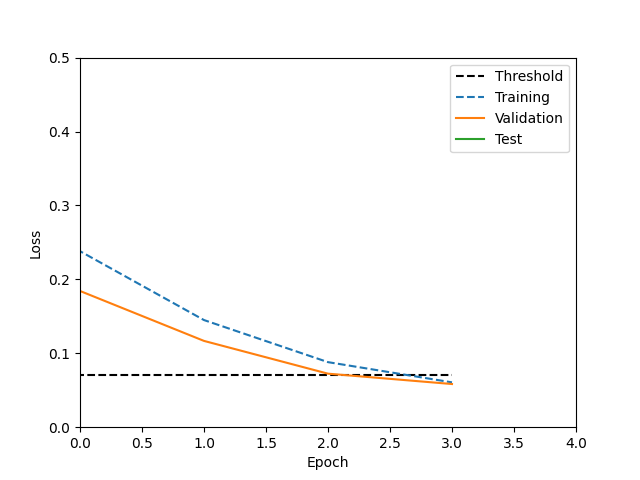

Done training.01/1001          
Recordings left: 247/250


<IPython.core.display.Javascript object>


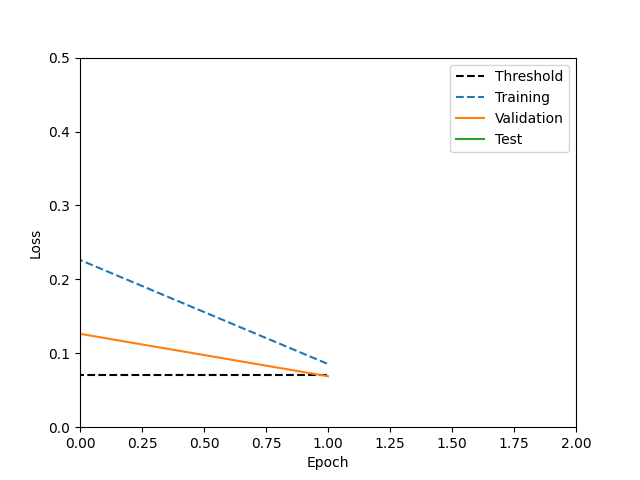

Done training.67/1067          
[0.5321637  0.58380497]ding 3/249
[0.5633409  0.61640424]
[0.687558  0.4199632]
[0.58924025 0.6195614 ]
[0.48112944 0.80762076]
[0.4529355  0.58583206]
[0.42109424 0.61500776]
[0.46084863 0.5480125 ]
[0.444204 0.413098]ecording 6/249
[0.4703884 0.5918221]
[0.5247303  0.53770214]ding 8/249
[0.5721475 0.4564137]
[0.64456373 0.45941052]
[0.55539393 0.55408484]ding 12/249
[0.4067169  0.43549502]
[0.53456175 0.4663117 ]ding 15/249
[0.61891216 0.42466378]
[0.67434555 0.5477261 ]
[0.65492934 0.58633786]
[0.541996   0.41507354]
[0.72070724 0.43146238]ding 16/249
[0.4462629  0.41934076]
[0.40131834 0.44208103]
[0.4823066  0.71132505]
[0.5924454 0.631998 ]
[0.5365563 0.7106857]
[0.5854986 0.7947981]
[0.47524023 0.49358806]
[0.41190952 0.45213836]ding 18/249
[0.58109707 0.552132  ]ding 19/249
[0.4812325  0.69063616]
[0.43883163 0.46069735]
[0.67670447 0.44285437]
[0.5592025 0.8591831]
[0.4537266  0.49460974]
[0.53402597 0.7085996 ]
[0.5627032  0.64711964]
[0.524304

[0.62287116 0.68437165]
[0.66854846 0.7309046 ]
[0.7748182 0.5509144]
[0.7410929  0.41883278]
[0.4889345  0.69955623]
[0.63337135 0.71040845]
[0.5419393 0.6688861]
[0.603191  0.7121949]
[0.86528593 0.446916  ]
[0.7512037  0.59844804]
[0.63512677 0.7043138 ]
[0.74462205 0.5657534 ]
[0.69249696 0.68755376]
[0.6223377  0.52643174]
[0.43720186 0.8770286 ]
[0.62174785 0.518176  ]
[0.73183334 0.74810606]
[0.54821295 0.7103653 ]
[0.60669637 0.5073055 ]
[0.84448445 0.42576173]
[0.5264856  0.49828872]
[0.4016397 0.8159028]
[0.6629822 0.6735666]
[0.42719218 0.5230145 ]
[0.7010911  0.45311153]ding 123/249
[0.4433266  0.65359306]
[0.41356114 0.6751403 ]
[0.573605   0.43194506]
[0.51998633 0.60744303]ding 125/249
[0.5117557 0.5145453]
[0.42344987 0.48153758]
[0.54124826 0.4102816 ]
[0.54131347 0.56764126]
[0.60398006 0.43758044]
[0.5281344  0.47173166]ding 126/249
[0.41906694 0.54788804]
[0.5287993 0.4915635]
[0.41187403 0.43361673]ding 128/249
[0.6679109 0.5068482]ording 130/249
[0.64506924 0.5726

[0.5141932  0.41675633]
[0.4559495  0.55967754]
[0.64658564 0.46436208]
[0.43796933 0.4020323 ]
[0.55647206 0.49030668]
[0.6884574  0.41092804]
[0.42317197 0.5957281 ]ding 4/250
[0.5875834  0.42647552]
[0.6170911 0.5359855]ording 5/250
[0.42848146 0.829664  ]
[0.5518437 0.7650185]
[0.63441414 0.71508974]
[0.65904003 0.6864046 ]
[0.46128988 0.665872  ]ding 6/250
[0.52665794 0.442661  ]
[0.5641956  0.40094444]ding 7/250
[0.40242627 0.49430588]
[0.47672632 0.5013029 ]
[0.431885   0.43534172]
[0.45108792 0.5579868 ]
[0.5475518  0.41428736]
[0.51144207 0.60237455]
[0.4720004  0.56684136]
[0.5759217 0.5283051]
[0.5544601  0.52240354]
[0.43237737 0.63566893]
[0.5328232 0.4161488]ording 8/250
[0.7654122  0.51145566]
[0.8209347  0.44362614]
[0.4770082  0.49458024]
[0.53150874 0.41446477]
[0.5306339 0.6047241]
[0.6044953  0.43820053]ding 9/250
[0.44219765 0.5532294 ]
[0.6403747  0.65280014]
[0.6164149 0.6007116]
[0.913112   0.40184155]
[0.7898969  0.40175927]
[0.87451315 0.49922332]
[0.83619225 

[0.59246606 0.4356841 ]ding 97/250
[0.48157474 0.45621714]ding 98/250
[0.45051214 0.6016823 ]
[0.46106514 0.47443068]
[0.50543815 0.4994395 ]
[0.53557247 0.4780373 ]ding 99/250
[0.5424594 0.5471344]
[0.5680014  0.48557898]
[0.4045923  0.52861935]
[0.50007194 0.49571553]
[0.5678439 0.4940334]
[0.4075851  0.48694414]
[0.40626115 0.57090944]
[0.5662954  0.41637594]
[0.59770864 0.52040094]
[0.5417959 0.5659727]
[0.47645035 0.5992823 ]
[0.5903889  0.43869385]
[0.7179416 0.6122767]ording 100/250
[0.42234883 0.6003541 ]ding 102/250
[0.7434501 0.4854777]
[0.6998247 0.5569947]
[0.4048706 0.511094 ]ording 103/250
[0.6410728 0.4155939]
[0.6807586  0.43687782]
[0.53549165 0.542851  ]
[0.51826257 0.577818  ]
[0.57565796 0.4995241 ]
[0.5524878  0.49532574]
[0.51411617 0.5606533 ]
[0.6991807  0.40559992]
[0.7640226 0.439087 ]
[0.8048133  0.70204914]ding 105/250
[0.55399114 0.82767904]
[0.4712933 0.9242679]
[0.5031261  0.88359344]
[0.6460248 0.844951 ]
[0.4581636 0.8987208]
[0.6494695  0.86824393]
[0.

[0.88965625 0.42619333]
[0.75155276 0.44541702]
[0.5683088  0.41716942]
[0.53062975 0.65240353]
[0.6403241 0.4913528]
[0.74804604 0.48312646]
[0.83072466 0.43264154]
[0.43744773 0.7157777 ]
[0.41966826 0.610787  ]
[0.71578264 0.45335847]
[0.6281328 0.5041294]
[0.57177544 0.4351465 ]
[0.7004463  0.45467362]
[0.46854633 0.7075482 ]
[0.41701993 0.49895364]
[0.46237925 0.7470654 ]
[0.5234573 0.5484873]
[0.6608697 0.5679131]
[0.6445546 0.4122881]
[0.6338468 0.5641477]
[0.4109699 0.6149303]
[0.46681938 0.6662499 ]
[0.68937933 0.4238923 ]
[0.5882986  0.49582058]
[0.57094145 0.5327318 ]
[0.53159326 0.60305303]
[0.87515086 0.42383403]
[0.55973774 0.6526114 ]
[0.42115384 0.7144887 ]
[0.74844986 0.49949148]
[0.46547264 0.83548146]
[0.43267077 0.550081  ]
[0.48293656 0.716082  ]
[0.5267373  0.40903375]
[0.58162516 0.54486614]
[0.47537887 0.5464738 ]
[0.6693259  0.48209625]
[0.46805963 0.627093  ]
[0.6482709  0.45124662]
[0.4499433  0.73546195]
[0.5672416 0.6609229]
[0.65878797 0.47987255]
[0.57066

[0.40713033 0.5774127 ]
[0.45994    0.50113547]
[0.6562228  0.48401785]ding 220/250
[0.45017645 0.41518036]
[0.5972222  0.45334917]
[0.7943738 0.5287347]
[0.70381415 0.5759804 ]
[0.4303684 0.6675288]
[0.5235879 0.5714546]
[0.60432905 0.49043956]
[0.86842054 0.4352135 ]
[0.49700055 0.6056113 ]
[0.71558386 0.5791866 ]
[0.66956294 0.6228825 ]
[0.6873608  0.46564853]
[0.4881554 0.4516367]
[0.8870859 0.4608308]
[0.43426114 0.58731556]
[0.7249702 0.6315295]
[0.8076458  0.57810545]
[0.7827385  0.55974406]
[0.4657869  0.57105947]
[0.8031288 0.4140965]
[0.44172782 0.72845125]
[0.45182747 0.6058685 ]
[0.4031084 0.6398184]
[0.4385173 0.4952228]
[0.4466455  0.69974184]
[0.45093256 0.72967017]
[0.6413441 0.5341718]
[0.4914132  0.41559032]
[0.4451193 0.7696517]
[0.54369396 0.42444727]ding 221/250
[0.4216903  0.72477585]
[0.44997314 0.50198126]
[0.46699974 0.48568183]
[0.42487875 0.5685242 ]
[0.59458214 0.54589087]
[0.7630518  0.46832168]
[0.55625707 0.42802793]ding 223/250
[0.6008086 0.5251858]
[0.6

<IPython.core.display.Javascript object>


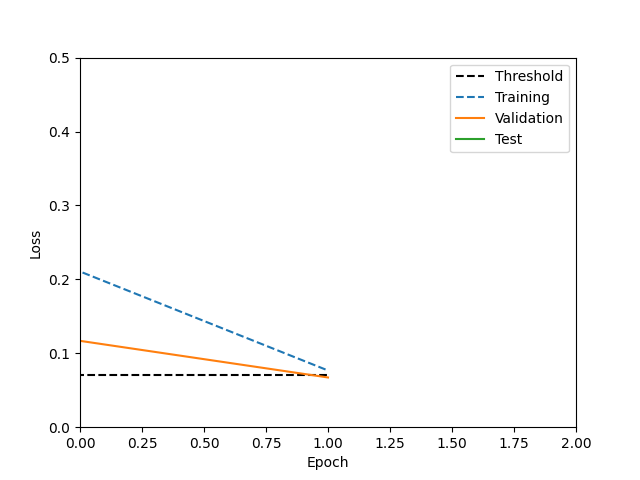

Done training.50/1150          
Recordings left: 247/250


<IPython.core.display.Javascript object>


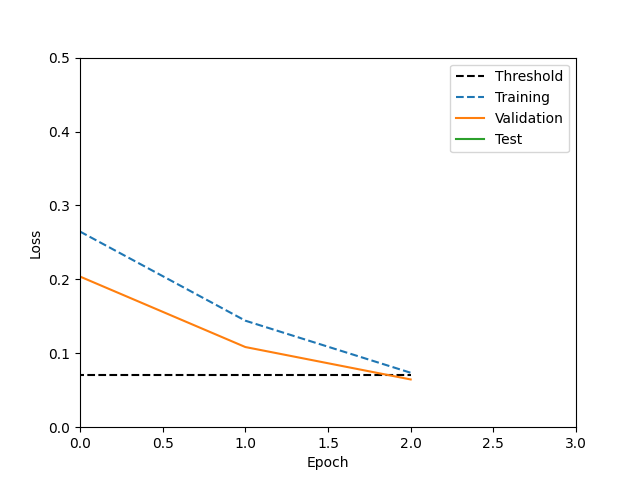

Done training.57/1157          
[0.4718788 0.4574057]ording 3/249
[0.49458194 0.45045626]ding 5/249
[0.43621427 0.61786044]ding 15/249
[0.64294857 0.51704574]ding 24/249
[0.6640269 0.4760215]ording 27/249
[0.6061546  0.49101108]ding 30/249
[0.42264912 0.59340006]
[0.41758242 0.6690868 ]
[0.63477397 0.5805798 ]ding 31/249
[0.46834207 0.49258116]
[0.45675385 0.5509879 ]
[0.4559858  0.40802315]ding 41/249
[0.52595484 0.47660363]ding 43/249
[0.456057   0.44429916]
[0.4568763  0.40533563]
[0.61617255 0.42793527]
[0.56514496 0.40512022]
[0.42071813 0.6003568 ]
[0.47241688 0.42073226]ding 51/249
[0.5055405  0.56574076]ding 55/249
[0.49446747 0.5107591 ]
[0.5026263  0.46760765]ding 60/249
[0.45190316 0.5541125 ]ding 62/249
[0.44131708 0.40524834]ding 69/249
[0.6393757 0.4772808]ording 71/249
[0.69087696 0.4026737 ]
[0.63227016 0.42696348]
[0.54941165 0.6153805 ]
[0.6790727  0.54812217]
[0.59082735 0.6061652 ]
[0.42281815 0.5586016 ]
[0.46551013 0.5806148 ]
[0.5069348 0.5133311]
[0.55693305 0.5

[0.6039286  0.58726096]
[0.57339185 0.42008898]
[0.7125737  0.50644726]
[0.7046003 0.7592501]ording 20/250
[0.7536283  0.72870666]
[0.88416076 0.6738378 ]
[0.75101477 0.91223425]
[0.8004628  0.71491486]
[0.8777813  0.71504396]
[0.8772128 0.8371595]
[0.94153345 0.5187979 ]
[0.7513419 0.6573002]
[0.9092272 0.7395593]
[0.9328635 0.4039534]
[0.91529804 0.42208734]
[0.9412502 0.4889814]
[0.66513634 0.804433  ]
[0.9635863  0.49229902]
[0.9270907 0.4751175]
[0.97960883 0.57439077]
[0.893471   0.77330714]
[0.86171347 0.4929147 ]
[0.95828724 0.5083292 ]
[0.7341369 0.8337094]
[0.8814499  0.58624953]
[0.5087136  0.83125407]
[0.7926569  0.73791105]
[0.65177596 0.8470819 ]
[0.9302262 0.748958 ]
[0.9746304  0.46229342]
[0.8614407 0.871508 ]
[0.75802493 0.8588379 ]
[0.8120559 0.730894 ]
[0.92997044 0.60225606]
[0.43169418 0.90853983]
[0.89681226 0.57067955]
[0.5907294 0.7061785]
[0.57467   0.9235017]
[0.46183956 0.93468636]
[0.50719243 0.8385368 ]
[0.8069737 0.8068865]
[0.86168885 0.8690567 ]
[0.9719

[0.43315268 0.556784  ]
[0.8219159  0.41256142]
[0.5805732 0.7084671]
[0.62824315 0.48732626]
[0.4656154  0.50147295]
[0.41223305 0.6676321 ]
[0.60428804 0.66929865]
[0.7036321  0.42575327]
[0.579831   0.48566097]ding 78/250
[0.8744254  0.53075266]
[0.45520467 0.49600857]
[0.48982197 0.67807347]
[0.83435917 0.4547957 ]
[0.9072499  0.54806066]
[0.71101147 0.48886737]
[0.61645657 0.6137591 ]
[0.80430543 0.44666952]ding 80/250
[0.68308324 0.43107012]
[0.40580767 0.68484545]
[0.6034833  0.49856687]
[0.77339745 0.5404021 ]
[0.59810615 0.4030001 ]
[0.6461593  0.41036952]
[0.41012314 0.66520774]
[0.44883767 0.66834486]
[0.48630175 0.7059253 ]
[0.5764306 0.7897485]
[0.47407472 0.77942723]
[0.41275898 0.6332662 ]
[0.61799914 0.5832182 ]
[0.4928729  0.58572763]
[0.47001755 0.66081023]
[0.85270673 0.43779996]
[0.69983345 0.48731333]
[0.7999668 0.4107464]
[0.6123329  0.79146457]
[0.4386426 0.5439647]ording 83/250
[0.519122  0.4528457]
[0.50575924 0.4992082 ]ding 84/250
[0.573579   0.61806446]
[0.4

[0.51434666 0.46936837]ding 131/250
[0.89675695 0.53293025]
[0.7715368  0.44732213]
[0.5229963  0.42910412]
[0.5123884  0.40006337]
[0.42414075 0.7691026 ]
[0.6672944  0.73150164]ding 132/250
[0.94938874 0.49349084]
[0.81431097 0.6808616 ]
[0.43761936 0.7682431 ]
[0.9393779  0.68148947]
[0.54739946 0.9331991 ]
[0.5999689 0.6671643]
[0.8409875  0.46479967]
[0.85597754 0.7858973 ]
[0.96143085 0.45023793]
[0.93642586 0.49241266]
[0.9330513 0.5600917]
[0.6651506 0.9191036]
[0.728525  0.5929424]
[0.70967114 0.4205728 ]
[0.84844124 0.52755415]
[0.67814684 0.5627864 ]
[0.74419016 0.5101182 ]
[0.8843345  0.75493824]
[0.41697454 0.93673426]
[0.74559    0.43010306]
[0.62488437 0.71016645]
[0.69708526 0.71162134]
[0.94541013 0.43829456]
[0.4720581 0.544968 ]
[0.5344102 0.7549115]
[0.9453133  0.59029204]
[0.44753632 0.7323212 ]
[0.5741622  0.70292455]
[0.9575694 0.5473434]
[0.6626727  0.47239164]ding 133/250
[0.5253231  0.59004706]
[0.5462589  0.45729825]
[0.5137531  0.42093694]
[0.40037516 0.5569

[0.51394856 0.51389354]
[0.8841488  0.42824996]
[0.6609954 0.5112896]
[0.76831853 0.4768216 ]
[0.75635946 0.5389154 ]
[0.47159806 0.6739621 ]
[0.85365576 0.48935878]
[0.62428063 0.688408  ]
[0.45017743 0.78033257]
[0.9372962  0.44411516]
[0.53610414 0.9470357 ]
[0.41507846 0.56888705]
[0.8360327 0.5625217]
[0.55296516 0.59680337]
[0.4618885 0.5566062]
[0.4671534 0.9048847]
[0.48422077 0.7735557 ]
[0.48195252 0.522084  ]
[0.5773155  0.70902044]
[0.6871138  0.43675295]
[0.45042259 0.66479236]
[0.5491997 0.53472  ]
[0.5633428 0.7791202]
[0.84869456 0.46037263]
[0.5497302 0.4718715]
[0.65678865 0.43880978]
[0.47747448 0.7927481 ]
[0.88297987 0.4249444 ]
[0.8675039 0.542859 ]
[0.59186566 0.64856416]
[0.4399825 0.8303791]
[0.5031485 0.5670751]
[0.4518133 0.8601642]
[0.6721976 0.6109254]
[0.5859148  0.74960166]
[0.7837463 0.7707805]
[0.62441826 0.6488234 ]
[0.6678323 0.5603472]
[0.43604466 0.7575444 ]
[0.43344072 0.77751774]
[0.5797118  0.44874915]
[0.69464517 0.46478084]
[0.41843018 0.68105 

[0.6499596  0.54814816]
[0.69448376 0.55462354]ding 200/250
[0.62247646 0.65408766]
[0.53101873 0.80478865]
[0.9593434  0.41191477]
[0.9239549 0.4185783]
[0.8989597  0.40758562]
[0.7414435  0.65047854]
[0.62438405 0.42264664]
[0.45479465 0.51356393]
[0.6902584 0.5797441]
[0.4644535  0.64706016]
[0.4298641 0.4704263]
[0.44685236 0.5210864 ]
[0.7267102  0.53039664]
[0.83689576 0.4233776 ]
[0.8797642 0.4719547]ording 204/250
[0.64423656 0.5872741 ]
[0.4884637  0.42962876]
[0.45123088 0.6052496 ]
[0.5274372  0.62677324]
[0.50630367 0.61531395]
[0.8336698 0.5538115]
[0.891956   0.41357118]
[0.54925686 0.65816593]
[0.40271714 0.7215511 ]
[0.61764    0.73029035]
[0.8280128  0.65786576]
[0.68719137 0.8086391 ]
[0.5420815  0.54713094]
[0.41261068 0.5752304 ]ding 205/250
[0.61902416 0.44097063]
[0.40830824 0.8179599 ]
[0.55570453 0.41845664]
[0.5580417 0.7295878]
[0.8193576 0.41412  ]ording 206/250
[0.57171035 0.44622743]
[0.84825224 0.5385867 ]
[0.59720963 0.7435174 ]
[0.80768025 0.644052  ]
[0

<IPython.core.display.Javascript object>


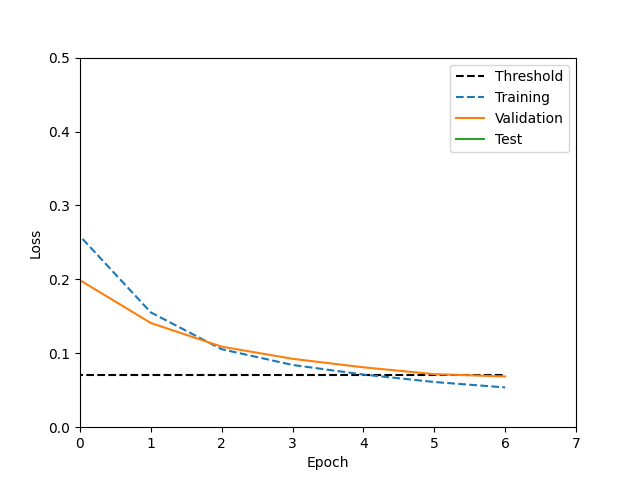

Done training.3/993          
Recordings left: 247/250


<IPython.core.display.Javascript object>


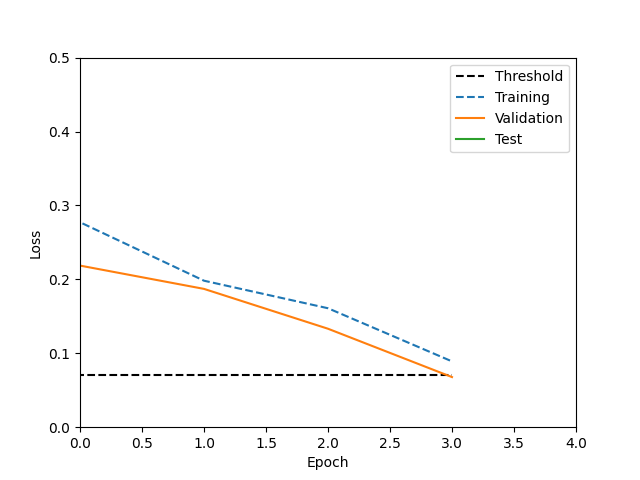

Done training.08/1008          
[0.41010597 0.69282746]ding 1/249
[0.49495015 0.44123054]
[0.49854115 0.41161066]ding 2/249
[0.445791  0.5265911]ording 3/249
[0.5245783  0.41713154]
[0.40446663 0.5535807 ]ding 4/249
[0.4952454  0.53903407]
[0.63369274 0.5188462 ]ding 6/249
[0.6340425  0.44149566]
[0.41486704 0.5130551 ]
[0.50073606 0.44118005]
[0.53790563 0.48613334]
[0.584548  0.4217311]ording 8/249
[0.5983413 0.5300363]ording 10/249
[0.49590126 0.7613103 ]
[0.45202157 0.8530959 ]
[0.5062528  0.63405246]
[0.68727684 0.65310466]
[0.80552334 0.42925906]
[0.4830079 0.6326852]
[0.54918414 0.44137996]
[0.40117425 0.52417505]ding 11/249
[0.46072885 0.4278946 ]
[0.41514552 0.6450394 ]
[0.41759494 0.57582563]
[0.45357057 0.55491894]ding 13/249
[0.4481545 0.4226474]ording 14/249
[0.5225768  0.50548536]
[0.4877323  0.40143445]
[0.66079366 0.4160644 ]
[0.5920365  0.57329553]
[0.45751375 0.575518  ]ding 15/249
[0.5421899  0.46734607]
[0.41245073 0.4626616 ]ding 16/249
[0.49318886 0.55029553]ding 

[0.5481106 0.4040869]
[0.6776388  0.41581893]
[0.62847924 0.53255653]
[0.49932155 0.42971522]ding 80/249
[0.4112834 0.445635 ]
[0.5295453 0.4133119]
[0.54769564 0.5611547 ]
[0.46018282 0.42127103]
[0.43041298 0.43761662]ding 81/249
[0.48463112 0.48874545]
[0.5737176 0.4756485]ording 82/249
[0.4892815  0.48975238]ding 83/249
[0.4146815  0.42796373]
[0.41411957 0.667485  ]ding 88/249
[0.6148281  0.51257545]
[0.6171491  0.40759054]
[0.4195119 0.5792467]
[0.4556508 0.6782037]
[0.4765517 0.660981 ]
[0.78303975 0.46413532]
[0.50036246 0.46182114]
[0.5011977  0.64671063]
[0.43344674 0.5530763 ]
[0.78971875 0.43785572]
[0.44026306 0.5843051 ]
[0.44834027 0.8452623 ]
[0.6379525 0.6412003]
[0.46888492 0.5806549 ]
[0.8080356  0.46683082]
[0.59771174 0.5565793 ]
[0.45146015 0.75215983]
[0.41917118 0.7716363 ]
[0.43455663 0.58580637]
[0.45393726 0.6617624 ]
[0.48584154 0.80397135]
[0.6104982 0.5989675]
[0.5905367 0.675729 ]
[0.5548359 0.6420424]
[0.6811768  0.47498965]
[0.47646853 0.58551586]
[0.47

[0.58545315 0.662664  ]ding 138/249
[0.53262144 0.46184933]ding 139/249
[0.5380264  0.60961574]
[0.472587   0.46835765]ding 140/249
[0.40254277 0.6768473 ]
[0.42405206 0.7963558 ]ding 141/249
[0.4117456  0.69287306]
[0.4986421  0.54908913]
[0.46889073 0.6349791 ]ding 142/249
[0.77025014 0.5213995 ]
[0.7293803 0.6520102]
[0.48188567 0.6937756 ]
[0.50801057 0.51826376]
[0.66323984 0.48475862]
[0.48669404 0.601465  ]
[0.457318  0.7024803]
[0.49399826 0.74599457]
[0.7443529  0.42300108]
[0.6785168  0.47852832]
[0.42506054 0.8893492 ]
[0.8256797  0.49476618]
[0.7481916  0.49630532]
[0.8130735  0.55291706]
[0.67730117 0.50365084]
[0.450306  0.8269131]ording 145/249
[0.6228561  0.51036054]
[0.5069577  0.57568556]
[0.50170445 0.55848396]
[0.40900832 0.53868186]
[0.4621874  0.42687598]
[0.425383  0.4417098]
[0.42379105 0.48718643]
[0.45626047 0.40821013]
[0.40870556 0.4826047 ]
[0.5374368 0.6321013]
[0.41609392 0.62346953]
[0.44488588 0.7572487 ]
[0.4066185  0.57450163]
[0.654195   0.47474134]


[0.74632573 0.58545077]
[0.6054293  0.41948807]
[0.7844775  0.42749536]
[0.5104258 0.6147355]ording 215/249
[0.6315652  0.46829826]
[0.44816643 0.54323167]
[0.6808317  0.41802472]ding 216/249
[0.516194   0.41426617]
[0.42993537 0.6575182 ]
[0.4402904  0.47936666]
[0.4707206  0.40371668]
[0.41212046 0.41324943]ding 217/249
[0.47646177 0.45479912]ding 218/249
[0.4155004 0.4694583]
[0.5253867  0.42114285]
[0.53266096 0.5101818 ]
[0.6117786  0.40759525]
[0.627183   0.41721392]ding 219/249
[0.4361407 0.5319824]ording 224/249
[0.51339775 0.44742617]
[0.44087982 0.5215697 ]
[0.4839477  0.61088574]
[0.42066312 0.4532237 ]
[0.43060574 0.5054465 ]ding 226/249
[0.6398     0.46715516]ding 227/249
[0.42126307 0.48156428]
[0.5833604 0.439279 ]ording 228/249
[0.54116344 0.5171544 ]
[0.51628596 0.47064018]
[0.45185012 0.41826144]
[0.56830263 0.43760437]ding 230/249
[0.5897511 0.5103577]
[0.50518954 0.48304558]
[0.5207601 0.597574 ]ording 231/249
[0.4422509 0.4649739]
[0.48652434 0.57814693]
[0.547917 

[0.67169654 0.699842  ]
[0.60978025 0.629688  ]
[0.8818934 0.452761 ]
[0.7863321 0.4816299]
[0.506958   0.45527384]
[0.5115752  0.76795685]
[0.5770049  0.81490004]
[0.4788989 0.468112 ]
[0.41584152 0.48390123]
[0.5023354  0.45521685]
[0.7877313 0.4272836]
[0.6444645  0.68441683]
[0.8175861 0.5564759]
[0.8750621  0.83149326]ding 22/250
[0.9466102  0.44580597]
[0.738581  0.9356281]
[0.83046216 0.84691334]
[0.6607426  0.76814336]
[0.91213584 0.48993555]
[0.67935455 0.8864401 ]
[0.45078382 0.982645  ]
[0.77798295 0.77772933]
[0.5956366  0.80755913]
[0.8132005  0.69053435]
[0.8245204  0.67406857]
[0.5983834 0.8606172]
[0.9179312  0.72205347]
[0.9069661  0.51363635]
[0.9527553 0.4250863]
[0.74327624 0.58971685]
[0.5387573  0.47018698]
[0.47973743 0.8953519 ]
[0.40292096 0.96868515]
[0.7289159  0.71358985]
[0.5760422  0.94978976]
[0.7005469 0.942894 ]
[0.6705004  0.64738464]
[0.50402284 0.46875966]
[0.42458418 0.88027835]
[0.7953416  0.47966072]
[0.56844413 0.8074955 ]
[0.6200203 0.8598285]
[

[0.6425426 0.4290475]ording 61/250
[0.5053946  0.42957172]
[0.63980705 0.4467109 ]
[0.4532702  0.49340096]
[0.4827878  0.61602247]
[0.5521309 0.6022008]
[0.44924065 0.6431781 ]ding 62/250
[0.45458913 0.77936155]
[0.5819831 0.4282207]
[0.4468982  0.58080435]
[0.6331759  0.75036556]
[0.4129576 0.790118 ]
[0.49593958 0.6292813 ]ding 63/250
[0.8776826  0.41153035]
[0.622613  0.6041612]
[0.40578055 0.61502427]
[0.6223839 0.5034624]
[0.49001506 0.53441364]
[0.49465168 0.46136355]
[0.45183063 0.45734724]
[0.43732142 0.6472613 ]
[0.5627486 0.5704719]
[0.865131  0.4358135]
[0.4716887 0.8798644]ording 64/250
[0.6294151  0.56680846]
[0.5712386  0.77605116]
[0.5466381  0.72094524]
[0.55906475 0.41747916]
[0.42556915 0.8567557 ]ding 65/250
[0.40955952 0.8374654 ]
[0.58924264 0.76566255]
[0.79722536 0.47586158]
[0.75034076 0.5205287 ]
[0.72351336 0.5714983 ]
[0.71015334 0.41007122]ding 66/250
[0.61568    0.49288994]
[0.62927336 0.77018154]
[0.8140042  0.45507812]
[0.5196026  0.46387255]ding 67/250
[

[0.6725888  0.48609897]ding 109/250
[0.49200198 0.7154579 ]
[0.85178363 0.44061524]
[0.666186   0.92992276]ding 110/250
[0.586203   0.52829677]
[0.9136798  0.50080216]
[0.95550805 0.49634802]
[0.8876694  0.46855313]
[0.8626844 0.4966557]
[0.7868604 0.7460678]
[0.6702601  0.86741155]
[0.82395303 0.84571934]
[0.5498624 0.8123567]
[0.6433308 0.9192939]
[0.43040058 0.98162705]
[0.59622484 0.77981335]
[0.8893532 0.5250934]
[0.65486676 0.851635  ]
[0.79530865 0.5730482 ]
[0.71150523 0.67716223]
[0.42696366 0.744913  ]ding 111/250
[0.550614  0.5501705]
[0.6875128 0.6184525]
[0.5730215  0.42545804]
[0.7096805 0.4407771]ording 114/250
[0.57714796 0.40999922]
[0.5158539 0.4424454]
[0.409017   0.68723404]
[0.40494218 0.63261926]
[0.5776191 0.5288515]
[0.7512394 0.4149529]
[0.64227754 0.40269288]
[0.51311433 0.4520486 ]
[0.79161036 0.73485154]ding 115/250
[0.74029666 0.5102835 ]
[0.4064664 0.8308527]
[0.58390445 0.42726615]
[0.73248774 0.43012795]
[0.65522397 0.4816527 ]
[0.6000717  0.50454175]
[0

[0.5666986  0.62881947]ding 145/250
[0.49515903 0.54847866]
[0.5810466 0.4810695]
[0.7577095 0.5361343]ording 148/250
[0.5942273  0.57779175]
[0.607746  0.7195989]
[0.598929   0.67539364]
[0.44824943 0.572624  ]
[0.6229026  0.43057236]
[0.78590703 0.73104364]
[0.54499614 0.8252623 ]
[0.54008824 0.78212696]
[0.49939254 0.8158715 ]
[0.54422665 0.5868499 ]
[0.41579437 0.8168155 ]
[0.42793056 0.4532642 ]
[0.44716224 0.6400947 ]
[0.6584731 0.4389274]
[0.7209328  0.47319672]ding 149/250
[0.44422302 0.809037  ]ding 150/250
[0.6133621  0.57417876]
[0.6647503 0.5427937]
[0.54001576 0.45717385]
[0.8084257  0.54761434]
[0.559248  0.7547902]
[0.59099585 0.5420495 ]
[0.49004608 0.5194808 ]
[0.48983115 0.7489908 ]
[0.4521952  0.48707917]
[0.6493468 0.518931 ]
[0.5344866  0.74195313]
[0.54284173 0.58876115]
[0.5090861 0.8751749]
[0.45686898 0.9138124 ]
[0.60586554 0.7948515 ]
[0.72850406 0.56357867]
[0.73598427 0.42315263]
[0.83627903 0.4667401 ]
[0.52266914 0.48580396]
[0.4708087  0.51350987]ding 15

[0.5167063 0.6074123]ording 190/250
[0.44119254 0.5927893 ]
[0.4979066  0.46084192]
[0.7261225 0.7397151]ording 191/250
[0.7746371  0.69545573]ding 192/250
[0.7021602  0.65965724]
[0.5037319 0.7066655]
[0.6764279 0.6006163]
[0.7204253 0.5674919]
[0.65164256 0.5584377 ]
[0.56884474 0.5083723 ]
[0.623072  0.7031508]
[0.59413064 0.5325989 ]
[0.7712617  0.57881284]
[0.4751373 0.6574347]
[0.4160145 0.8679909]
[0.48250768 0.54177696]ding 193/250
[0.5317221 0.4147007]
[0.4497296  0.98092365]ding 194/250
[0.49987677 0.7373921 ]
[0.5318873 0.7943946]
[0.51918244 0.412816  ]
[0.74041927 0.45356008]
[0.44700706 0.4136592 ]ding 195/250
[0.747753  0.4410311]ording 196/250
[0.55032045 0.76883143]
[0.45306036 0.8372638 ]
[0.58614945 0.87084496]
[0.6631833  0.60110927]
[0.7179938  0.52128756]
[0.45686197 0.7806714 ]
[0.46285704 0.86609876]
[0.6678153 0.6470645]
[0.5473224  0.75591546]
[0.45040193 0.7807648 ]
[0.40902066 0.42219242]
[0.43099272 0.8457469 ]
[0.57898587 0.48472196]ding 197/250
[0.5967942

[0.4371193 0.959846 ]
[0.6422984 0.5705468]
[0.5282003  0.56366944]
[0.56111765 0.659697  ]
[0.68319654 0.7441521 ]
[0.47699198 0.76090634]
[0.53611636 0.46418816]
[0.71122104 0.5254099 ]ding 240/250
[0.50010616 0.8064379 ]
[0.5431397  0.75725955]
[0.58475775 0.49734908]
[0.42552832 0.67499924]
[0.4210896 0.7540725]
[0.42862296 0.57584774]
[0.49474522 0.5534441 ]
[0.4271057  0.48773664]
[0.6801788  0.45399135]ding 241/250
[0.6206718 0.743551 ]
[0.5004239  0.64451313]
[0.5912583  0.48173755]
[0.5842584 0.5087444]
[0.4439246 0.8073568]
[0.4931336  0.48800507]
[0.44026607 0.6145554 ]
[0.49001324 0.549635  ]
[0.46818414 0.50242877]
[0.42452297 0.4182662 ]
[0.8199859  0.46704218]ding 242/250
[0.9398609  0.52160704]
[0.90971917 0.5981047 ]
[0.77645904 0.58698905]
[0.63894373 0.80466837]
[0.8744576 0.6964734]
[0.6123627 0.5484687]
[0.6509068  0.40034103]ding 243/250
[0.4122164  0.74362344]
[0.81064194 0.4826887 ]
[0.5371269  0.84608245]
[0.7960356  0.43683067]
[0.58799547 0.7908326 ]
[0.48839

In [11]:
for vector in ['ivectors']:
    vector_length = 128 if vector == 'ivectors' else 128
    for models_generation_length in [20]:
        for i in range(3):
            print(vector, vector_length, models_generation_length, i)
            a_trainer = Trainer()
            a_net = a_trainer.get_net(balance_segments(a_recordings_segments,maximum_speakers_length,1,False),
                                      vector = vector,
                                      vector_length = vector_length,
                                      models_container_length = models_container_length,
                                      models_container_include_zeros = models_container_include_zeros,
                                      models_container_include_overlaps = models_container_include_overlaps,
                                      models_generation_lengths = [models_generation_length],
                                      models_generation_selection = models_generation_selection,
                                      balance_segments_selection = balance_segments_selection,
                                      batch_size = batch_size)
            b_trainer = Trainer()
            b_net = b_trainer.get_net(balance_segments(b_recordings_segments,maximum_speakers_length,1,False),
                                      vector = vector,
                                      vector_length = vector_length,
                                      models_container_length = models_container_length,
                                      models_container_include_zeros = models_container_include_zeros,
                                      models_container_include_overlaps = models_container_include_overlaps,
                                      models_generation_lengths = [models_generation_length],
                                      models_generation_selection = models_generation_selection,
                                      balance_segments_selection = balance_segments_selection,
                                      batch_size = batch_size)
            
            test_id = '20200505_callhome_fc_overlaps_' + vector + '_' + str(models_generation_length) + '_' + str(i)
            
            a_results = tracking_tester(a_recordings_test_segments,
                                        scoring_function = lambda vector, models_container: net_selector(vector, models_container, b_net),
                                        groundtruth_filepath = a_groundtruth,
                                        groundtruth_valid_speakers_ids = ['A', 'B'],
                                        vector = vector,
                                        models_container_length = models_container_length,
                                        models_container_include_overlaps = models_container_include_overlaps,
                                        models_generation_length = models_generation_length,
                                        models_generation_selection = models_generation_selection,
                                        save_dir = 'batch/' + test_id + '_a')
        

            b_results = tracking_tester(b_recordings_test_segments,
                                        scoring_function = lambda vector, models_container: net_selector(vector, models_container, a_net),
                                        groundtruth_filepath = b_groundtruth,
                                        groundtruth_valid_speakers_ids = ['A', 'B'],
                                        vector = vector,
                                        models_container_length = models_container_length,
                                        models_container_include_overlaps = models_container_include_overlaps,
                                        models_generation_length = models_generation_length,
                                        models_generation_selection = models_generation_selection,
                                        save_dir = 'batch/' + test_id + '_b')
            
            print(a_results)
            print(b_results)
            output_der = (a_results['der'] + b_results['der']) / 2
            output_eer = (a_results['eer'] + b_results['eer']) / 2
            output_dcf = (a_results['dcf'] + b_results['dcf']) / 2
            results = { 'der': output_der, 'eer': output_eer, 'dcf': output_dcf }
            print(results)
            
            file = open('batch/results.csv', 'a')
            file.write(test_id + ', ' + json.dumps(a_results) + ', ' + json.dumps(b_results) + ', ' + json.dumps(results) + '\n')
            file.close()